In [52]:
import pandas as pd
import numpy as np
import re
import requests
import bs4
import time
import pickle
import tqdm
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from pymystem3 import Mystem
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [42]:
# Для начала посмотрю на имеющиеся данные, это тестовая выборка
with open('data/test.csv', encoding='utf-8') as file:
    text = file.read().split('\n\n')
    test_reviews = [re.findall(r'<review>(.+)\</review>', review.replace('\n', ' '))[0] for review in text if review]
    print(f'Текст первого отзыва:\n{test_reviews[0]}')
    print('Количество отзывов в тестовой выборке:', len(test_reviews))

Текст первого отзыва:
Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти. Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться. 
Количество отзывов в тестовой выборке: 100


## Создание набора данных
 Посмотрев на отзывы, можно понять, что отзывы про телефоны, есть смысл собирать отзывы из интернета о телефонах. Создам класс парсера с сайта irecommend.ru (Первая вкладка google при запросе "сайт отзывов"). Этот сайт показался весьма удобным для парсинга, но есть и некоторые сложности/особенности. Во вкладке "мобильные телефоны" нам нужна вкладка "отзывы", эти отзывы и парсим. На сайте есть возможность быть заблокированным. Первая попытка обработки сайта привела к ошибке 521 Web Server Is Down. Это механизм защиты сайта, чтобы не получить ошибку в каждом запросе http я делаю искусственный time.sleep() на 11 секунд(можно менять).

In [43]:
class IRecommendParser:
    """Class for irecommend.ru mobile phone reviews parser."""
    
    def __init__(self):
        self.reviews = []
        self.y = []
        self.seconds_sleep = 11
    
    def _create_html_parser(self, url):
        time.sleep(self.seconds_sleep)
        request = requests.get(url)
        bs_parser = bs4.BeautifulSoup(request.text, 'html.parser')
        return bs_parser
        
    def create_reviews(self, reviews_page_url, print_info=False):
        parser_lvl1 = self._create_html_parser(reviews_page_url)
        for phone in parser_lvl1.find_all('div', attrs={'class', 'smTeaser plate teaser-item'}):
            review_url = phone.find('a', attrs={'class': 'more'}).attrs['href']
            parser_lvl2 = self._create_html_parser(f'https://irecommend.ru/{review_url}')
            
            review_body = parser_lvl2.find('div', attrs={'itemprop': 'reviewBody'})
            self.reviews.append(' '.join([p.text for p in review_body.find_all('p')]))
            review_rating = parser_lvl2.find('div',
                                             attrs={'class': 'starsRating'}).find('meta',
                                                                                         attrs={'itemprop': "ratingValue"})
            self.y.append(self.make_label(review_rating.attrs['content']))
            if print_info:
                print(f'At this moment we have {len(self.y)} samples')
        return self.reviews, self.y
            
    def make_label(self, rating):
        rating = float(rating)
        if rating > 3:
            return 1
        else:
            return 0

In [25]:
# Для начала в качестве проверки, что все работает нормально обработаю одну страницу
irecommend_parser = IRecommendParser()
one_page_reviews, one_page_y = irecommend_parser.create_reviews('https://irecommend.ru/catalog/reviews/55', print_info=True)

At this moment we have 1 samples
At this moment we have 2 samples
At this moment we have 3 samples
At this moment we have 4 samples
At this moment we have 5 samples
At this moment we have 6 samples
At this moment we have 7 samples
At this moment we have 8 samples
At this moment we have 9 samples
At this moment we have 10 samples
At this moment we have 11 samples
At this moment we have 12 samples
At this moment we have 13 samples
At this moment we have 14 samples
At this moment we have 15 samples
At this moment we have 16 samples
At this moment we have 17 samples
At this moment we have 18 samples
At this moment we have 19 samples
At this moment we have 20 samples


In [28]:
# Текст отзывов обработался нормально, можно убрать лишние символы и сериализировать результат в бинарном виде npy
with open('data/one_page_reviews.npy', 'wb') as f:
    np.save(f, np.array(list(map(lambda x: x.replace('\xa0', '').replace('\n', ''), one_page_reviews))))
with open('data/one_page_y.npy', 'wb') as f:
    np.save(f, np.array(one_page_y))

In [44]:
with open('data/one_page_reviews.npy', 'rb') as f:
    one_page_reviews = np.load(f)
    print(one_page_reviews)

['Здраствуйте, хочу поделица своим впечалением о самсунге с9+. Эта модель вышла самой топовой по сравнению с моделями выше так как у него мощный процесор, высокая производительность и есть разьем под наушники 3.5 и нету вырезов в экране капеле моно бровей и прочего а 2 не большие полосы снизу и сверху для игр очень удобно а главное он почти все тянет на высоких настройках графики. Очень качественно собран, красивое оформление. Удобно лежит в руке комфортно держать но при долгой игре в него нагриваеца, но не значительно, сильного дискомфорта не вызывает. Процесор очень быстрый и мощный. сам смартфон легкий и приятный на ощюпь.'
 'Для 2022 года самое то если у тебя не большой бюджет, я взяла и осталась очень довольна но нужно смотреть что бы работало абсалютно все. И главное не забывайте что это айфон и у него есть много своих плюсов. Брала себе и мужу оба остались очень довольны он любитель играть в игры, и теперь как говорит он они не лагают и не зависают. мне по его работе он тоже оче

In [27]:
# Спаршу остальные отзывы 100 страниц
irecommend_parser = IRecommendParser()
pages_urls =  [f'https://irecommend.ru/catalog/reviews/55?page={i}' for i in range(1, 100)]
all_reviews, all_y = [], []
for page_url in pages_urls:
    temp_reviews, temp_y = irecommend_parser.create_reviews(page_url, print_info=True)
    all_reviews = temp_reviews
    all_y = temp_y

At this moment we have 1 samples
At this moment we have 2 samples
At this moment we have 3 samples
At this moment we have 4 samples
At this moment we have 5 samples
At this moment we have 6 samples
At this moment we have 7 samples
At this moment we have 8 samples
At this moment we have 9 samples
At this moment we have 10 samples
At this moment we have 11 samples
At this moment we have 12 samples
At this moment we have 13 samples
At this moment we have 14 samples
At this moment we have 15 samples
At this moment we have 16 samples
At this moment we have 17 samples
At this moment we have 18 samples
At this moment we have 19 samples
At this moment we have 20 samples
At this moment we have 21 samples
At this moment we have 22 samples
At this moment we have 23 samples
At this moment we have 24 samples
At this moment we have 25 samples
At this moment we have 26 samples
At this moment we have 27 samples
At this moment we have 28 samples
At this moment we have 29 samples
At this moment we have 

At this moment we have 239 samples
At this moment we have 240 samples
At this moment we have 241 samples
At this moment we have 242 samples
At this moment we have 243 samples
At this moment we have 244 samples
At this moment we have 245 samples
At this moment we have 246 samples
At this moment we have 247 samples
At this moment we have 248 samples
At this moment we have 249 samples
At this moment we have 250 samples
At this moment we have 251 samples
At this moment we have 252 samples
At this moment we have 253 samples
At this moment we have 254 samples
At this moment we have 255 samples
At this moment we have 256 samples
At this moment we have 257 samples
At this moment we have 258 samples
At this moment we have 259 samples
At this moment we have 260 samples
At this moment we have 261 samples
At this moment we have 262 samples
At this moment we have 263 samples
At this moment we have 264 samples
At this moment we have 265 samples
At this moment we have 266 samples
At this moment we ha

At this moment we have 474 samples
At this moment we have 475 samples
At this moment we have 476 samples
At this moment we have 477 samples
At this moment we have 478 samples
At this moment we have 479 samples
At this moment we have 480 samples
At this moment we have 481 samples
At this moment we have 482 samples
At this moment we have 483 samples
At this moment we have 484 samples
At this moment we have 485 samples
At this moment we have 486 samples
At this moment we have 487 samples
At this moment we have 488 samples
At this moment we have 489 samples
At this moment we have 490 samples
At this moment we have 491 samples
At this moment we have 492 samples
At this moment we have 493 samples
At this moment we have 494 samples
At this moment we have 495 samples
At this moment we have 496 samples
At this moment we have 497 samples
At this moment we have 498 samples
At this moment we have 499 samples
At this moment we have 500 samples
At this moment we have 501 samples
At this moment we ha

In [28]:
print(f'Extracted before turning off the PC: {len(irecommend_parser.reviews)}')

Extracted before turning off the PC: 599


In [29]:
# ПК ушёл в спящий режим, сохраню полученные отзывы и продолжу
with open('data/599_reviews.npy', 'wb') as f:
    np.save(f, np.array(list(map(lambda x: x.replace('\xa0', '').replace('\n', ''), irecommend_parser.reviews))))
with open('data/599_y.npy', 'wb') as f:
    np.save(f, np.array(irecommend_parser.y))

In [45]:
# Поверка, что файл был записан корректно в npy файл
with open('data/599_reviews.npy', 'rb') as f:
    _reviews = np.load(f)
    print(len(_reviews))

599


Получил части набора данных при помощи парсера, дальше объединю их в один набор данных.

In [47]:
def load_reviews_y(f_reviews, f_y):
    with open(f_reviews, 'rb') as f:
        reviews = np.load(f)
    with open(f_y, 'rb') as f:
        y = np.load(f)
    return reviews, y

In [48]:
X_train = None
y_train = None
for f_reviews, f_y in zip(['one_page_reviews.npy', '928_reviews.npy', '479_reviews.npy', '599_reviews.npy'],
                          ['one_page_y.npy', '928_y.npy', '479_y.npy', '599_y.npy']):
    reviews, y = load_reviews_y('data/' + f_reviews, 'data/' + f_y)
    if not(X_train is None and y_train is None):
        X_train = np.concatenate((X_train, reviews))
        y_train = np.concatenate((y_train, y))
    else:
        X_train = reviews
        y_train = y

По итогу парсинга сайта с отзывами на телефоны, получаем чуть больше 2000 отзывов, что по идее должно хватить для достижения необходимого качества модели. В ином случае можно извлечь данных где нибудь ещё.

In [49]:
print('Total shape of reviews dataset:', X_train.shape, y_train.shape)

Total shape of reviews dataset: (2026,) (2026,)


In [48]:
# Сохраню в npy полный набор данных
with open('data/X_reviews.npy', 'wb') as f:
    np.save(f, X_train)
with open('data/y_reviews.npy', 'wb') as f:
    np.save(f, y_train)

По похожей логике извлеку отзывы с сайта hi-tech.mail.ru. Возможно это даст больше качество модели, чем больше хороших данных будет, тем лучше.

In [55]:
class HiTechParser:
    """Class for hi-tech.mail.ru mobile phone reviews parser."""
    
    def __init__(self):
        self.reviews = []
        self.y = []
        self.seconds_sleep = 0.5
    
    def _create_html_parser(self, url):
        time.sleep(self.seconds_sleep)
        request = requests.get(url)
        bs_parser = bs4.BeautifulSoup(request.text, 'html.parser')
        return bs_parser
        
    def create_reviews(self, reviews_page_url, print_info=False):
        parser_lvl1 = self._create_html_parser(reviews_page_url)
        for phone in parser_lvl1.find_all('a', attrs={'class':'p-catalog-card__link link-holder'}):
            phone_url = phone.attrs['href']
            parser_lvl2 = self._create_html_parser(f'https://hi-tech.mail.ru{phone_url}otzyvy/')
            
            phone_reviews = [review_text.text.replace('Плюсы', ' Плюсы ').replace('Минусы',' Минусы ').replace('Впечатления', ' Впечатления ')
                             for review_text in parser_lvl2.find_all('div', attrs={'class': 'p-model-review__text'})]
            phone_ratings = [self.make_label(rating.text)
                             for rating in parser_lvl2.find_all('span', attrs={'class': 'text text_bold_medium margin_left_10'})]
            
            if len(phone_reviews) == len(phone_ratings):
                self.y += phone_ratings
                self.reviews += phone_reviews
            
            if print_info:
                print(f'At this moment we have {len(self.y)} {len(self.reviews)} samples')
        return self.reviews, self.y
            
    def make_label(self, rating):
        rating = float(rating)
        if rating > 3:
            return 1
        else:
            return 0

In [56]:
# Спаршу 83 страницы отзывов телефонов сайта hi-tech.mail.ru
# Без вкладок "показать ещё"
hi_tech_parser = HiTechParser()
pages_urls =  [f'https://hi-tech.mail.ru/mobile-catalog/?page={i}' for i in range(1, 83)]
all_reviews, all_y = [], []
for page_url in tqdm.tqdm(pages_urls):
    temp_reviews, temp_y = hi_tech_parser.create_reviews(page_url, print_info=True)
    all_reviews = temp_reviews
    all_y = temp_y

  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

At this moment we have 7 7 samples
At this moment we have 14 14 samples
At this moment we have 18 18 samples
At this moment we have 18 18 samples
At this moment we have 30 30 samples
At this moment we have 42 42 samples
At this moment we have 54 54 samples
At this moment we have 66 66 samples
At this moment we have 78 78 samples
At this moment we have 90 90 samples
At this moment we have 102 102 samples
At this moment we have 114 114 samples
At this moment we have 126 126 samples
At this moment we have 138 138 samples
At this moment we have 150 150 samples
At this moment we have 162 162 samples
At this moment we have 174 174 samples
At this moment we have 186 186 samples
At this moment we have 198 198 samples
At this moment we have 210 210 samples
At this moment we have 222 222 samples
At this moment we have 234 234 samples
At this moment we have 246 246 samples
At this moment we have 258 258 samples
At this moment we have 265 265 samples
At this moment we have 272 272 samples
At this 

  1%|▉                                                                                | 1/82 [00:51<1:09:12, 51.27s/it]

At this moment we have 516 516 samples
At this moment we have 528 528 samples
At this moment we have 540 540 samples
At this moment we have 552 552 samples
At this moment we have 564 564 samples
At this moment we have 571 571 samples
At this moment we have 575 575 samples
At this moment we have 587 587 samples
At this moment we have 587 587 samples
At this moment we have 587 587 samples
At this moment we have 593 593 samples
At this moment we have 603 603 samples
At this moment we have 608 608 samples
At this moment we have 618 618 samples
At this moment we have 623 623 samples
At this moment we have 627 627 samples
At this moment we have 631 631 samples
At this moment we have 643 643 samples
At this moment we have 643 643 samples
At this moment we have 655 655 samples
At this moment we have 667 667 samples
At this moment we have 679 679 samples
At this moment we have 691 691 samples
At this moment we have 703 703 samples
At this moment we have 715 715 samples
At this moment we have 72

  2%|█▉                                                                               | 2/82 [01:41<1:07:34, 50.69s/it]

At this moment we have 914 914 samples
At this moment we have 926 926 samples
At this moment we have 938 938 samples
At this moment we have 950 950 samples
At this moment we have 962 962 samples
At this moment we have 974 974 samples
At this moment we have 986 986 samples
At this moment we have 998 998 samples
At this moment we have 1010 1010 samples
At this moment we have 1022 1022 samples
At this moment we have 1034 1034 samples
At this moment we have 1046 1046 samples
At this moment we have 1058 1058 samples
At this moment we have 1070 1070 samples
At this moment we have 1082 1082 samples
At this moment we have 1094 1094 samples
At this moment we have 1094 1094 samples
At this moment we have 1099 1099 samples
At this moment we have 1111 1111 samples
At this moment we have 1123 1123 samples
At this moment we have 1135 1135 samples
At this moment we have 1147 1147 samples
At this moment we have 1159 1159 samples
At this moment we have 1171 1171 samples
At this moment we have 1183 1183

  4%|██▉                                                                              | 3/82 [02:31<1:06:29, 50.50s/it]

At this moment we have 1452 1452 samples
At this moment we have 1464 1464 samples
At this moment we have 1476 1476 samples
At this moment we have 1488 1488 samples
At this moment we have 1500 1500 samples
At this moment we have 1512 1512 samples
At this moment we have 1524 1524 samples
At this moment we have 1536 1536 samples
At this moment we have 1548 1548 samples
At this moment we have 1560 1560 samples
At this moment we have 1572 1572 samples
At this moment we have 1584 1584 samples
At this moment we have 1596 1596 samples
At this moment we have 1608 1608 samples
At this moment we have 1620 1620 samples
At this moment we have 1632 1632 samples
At this moment we have 1644 1644 samples
At this moment we have 1656 1656 samples
At this moment we have 1668 1668 samples
At this moment we have 1680 1680 samples
At this moment we have 1692 1692 samples
At this moment we have 1704 1704 samples
At this moment we have 1716 1716 samples
At this moment we have 1728 1728 samples
At this moment w

  5%|███▉                                                                             | 4/82 [03:20<1:04:50, 49.88s/it]

At this moment we have 2028 2028 samples
At this moment we have 2040 2040 samples
At this moment we have 2051 2051 samples
At this moment we have 2063 2063 samples
At this moment we have 2075 2075 samples
At this moment we have 2087 2087 samples
At this moment we have 2099 2099 samples
At this moment we have 2111 2111 samples
At this moment we have 2123 2123 samples
At this moment we have 2132 2132 samples
At this moment we have 2144 2144 samples
At this moment we have 2153 2153 samples
At this moment we have 2164 2164 samples
At this moment we have 2172 2172 samples
At this moment we have 2180 2180 samples
At this moment we have 2192 2192 samples
At this moment we have 2204 2204 samples
At this moment we have 2216 2216 samples
At this moment we have 2225 2225 samples
At this moment we have 2234 2234 samples
At this moment we have 2243 2243 samples
At this moment we have 2250 2250 samples
At this moment we have 2258 2258 samples
At this moment we have 2270 2270 samples
At this moment w

  6%|████▉                                                                            | 5/82 [04:09<1:03:25, 49.42s/it]

At this moment we have 2532 2532 samples
At this moment we have 2539 2539 samples
At this moment we have 2547 2547 samples
At this moment we have 2554 2554 samples
At this moment we have 2559 2559 samples
At this moment we have 2564 2564 samples
At this moment we have 2570 2570 samples
At this moment we have 2577 2577 samples
At this moment we have 2589 2589 samples
At this moment we have 2595 2595 samples
At this moment we have 2599 2599 samples
At this moment we have 2603 2603 samples
At this moment we have 2603 2603 samples
At this moment we have 2608 2608 samples
At this moment we have 2613 2613 samples
At this moment we have 2622 2622 samples
At this moment we have 2629 2629 samples
At this moment we have 2634 2634 samples
At this moment we have 2640 2640 samples
At this moment we have 2643 2643 samples
At this moment we have 2648 2648 samples
At this moment we have 2659 2659 samples
At this moment we have 2659 2659 samples
At this moment we have 2666 2666 samples
At this moment w

  7%|█████▉                                                                           | 6/82 [04:58<1:02:19, 49.20s/it]

At this moment we have 2814 2814 samples
At this moment we have 2814 2814 samples
At this moment we have 2820 2820 samples
At this moment we have 2830 2830 samples
At this moment we have 2831 2831 samples
At this moment we have 2831 2831 samples
At this moment we have 2834 2834 samples
At this moment we have 2834 2834 samples
At this moment we have 2838 2838 samples
At this moment we have 2842 2842 samples
At this moment we have 2846 2846 samples
At this moment we have 2851 2851 samples
At this moment we have 2857 2857 samples
At this moment we have 2859 2859 samples
At this moment we have 2861 2861 samples
At this moment we have 2863 2863 samples
At this moment we have 2863 2863 samples
At this moment we have 2863 2863 samples
At this moment we have 2871 2871 samples
At this moment we have 2871 2871 samples
At this moment we have 2872 2872 samples
At this moment we have 2872 2872 samples
At this moment we have 2875 2875 samples
At this moment we have 2881 2881 samples
At this moment w

  9%|██████▉                                                                          | 7/82 [05:49<1:02:17, 49.84s/it]

At this moment we have 2972 2972 samples
At this moment we have 2974 2974 samples
At this moment we have 2978 2978 samples
At this moment we have 2990 2990 samples
At this moment we have 3002 3002 samples
At this moment we have 3002 3002 samples
At this moment we have 3014 3014 samples
At this moment we have 3026 3026 samples
At this moment we have 3026 3026 samples
At this moment we have 3026 3026 samples
At this moment we have 3026 3026 samples
At this moment we have 3038 3038 samples
At this moment we have 3042 3042 samples
At this moment we have 3042 3042 samples
At this moment we have 3042 3042 samples
At this moment we have 3054 3054 samples
At this moment we have 3054 3054 samples
At this moment we have 3066 3066 samples
At this moment we have 3078 3078 samples
At this moment we have 3090 3090 samples
At this moment we have 3102 3102 samples
At this moment we have 3114 3114 samples
At this moment we have 3114 3114 samples
At this moment we have 3126 3126 samples
At this moment w

 10%|███████▉                                                                         | 8/82 [06:40<1:02:01, 50.28s/it]

At this moment we have 3304 3304 samples
At this moment we have 3304 3304 samples
At this moment we have 3316 3316 samples
At this moment we have 3328 3328 samples
At this moment we have 3332 3332 samples
At this moment we have 3344 3344 samples
At this moment we have 3356 3356 samples
At this moment we have 3368 3368 samples
At this moment we have 3380 3380 samples
At this moment we have 3380 3380 samples
At this moment we have 3380 3380 samples
At this moment we have 3380 3380 samples
At this moment we have 3385 3385 samples
At this moment we have 3397 3397 samples
At this moment we have 3397 3397 samples
At this moment we have 3398 3398 samples
At this moment we have 3399 3399 samples
At this moment we have 3399 3399 samples
At this moment we have 3399 3399 samples
At this moment we have 3399 3399 samples
At this moment we have 3399 3399 samples
At this moment we have 3411 3411 samples
At this moment we have 3422 3422 samples
At this moment we have 3422 3422 samples
At this moment w

 11%|████████▉                                                                        | 9/82 [07:34<1:02:37, 51.48s/it]

At this moment we have 3556 3556 samples
At this moment we have 3568 3568 samples
At this moment we have 3568 3568 samples
At this moment we have 3568 3568 samples
At this moment we have 3568 3568 samples
At this moment we have 3568 3568 samples
At this moment we have 3580 3580 samples
At this moment we have 3580 3580 samples
At this moment we have 3580 3580 samples
At this moment we have 3580 3580 samples
At this moment we have 3580 3580 samples
At this moment we have 3580 3580 samples
At this moment we have 3580 3580 samples
At this moment we have 3591 3591 samples
At this moment we have 3591 3591 samples
At this moment we have 3591 3591 samples
At this moment we have 3602 3602 samples
At this moment we have 3602 3602 samples
At this moment we have 3602 3602 samples
At this moment we have 3602 3602 samples
At this moment we have 3602 3602 samples
At this moment we have 3610 3610 samples
At this moment we have 3610 3610 samples
At this moment we have 3610 3610 samples
At this moment w

 12%|█████████▊                                                                      | 10/82 [08:30<1:03:31, 52.93s/it]

At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3676 3676 samples
At this moment we have 3688 3688 samples
At this moment we have 3688 3688 samples
At this moment we have 3688 3688 samples
At this moment we have 3688 3688 samples
At this moment we have 3688 3688 samples
At this moment we have 3688 3688 samples
At this moment we have 3688 3688 samples
At this moment we have 3696 3696 samples
At this moment we have 3703 3703 samples
At this moment we have 3713 3713 samples
At this moment we have 3720 3720 samples
At this moment we have 3727 3727 samples
At this moment we have 3727 3727 samples
At this moment we have 3739 3739 samples
At this moment we have 3739 3739 samples
At this moment w

 13%|██████████▋                                                                     | 11/82 [09:24<1:02:45, 53.03s/it]

At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3802 3802 samples
At this moment we have 3803 3803 samples
At this moment we have 3803 3803 samples
At this moment we have 3803 3803 samples
At this moment we have 3804 3804 samples
At this moment we have 3804 3804 samples
At this moment we have 3804 3804 samples
At this moment we have 3805 3805 samples
At this moment we have 3807 3807 samples
At this moment we have 3807 3807 samples
At this moment w

 15%|███████████▋                                                                    | 12/82 [10:23<1:04:09, 55.00s/it]

At this moment we have 3812 3812 samples
At this moment we have 3812 3812 samples
At this moment we have 3812 3812 samples
At this moment we have 3813 3813 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3815 3815 samples
At this moment we have 3816 3816 samples
At this moment we have 3816 3816 samples
At this moment we have 3816 3816 samples
At this moment we have 3816 3816 samples
At this moment we have 3816 3816 samples
At this moment we have 3816 3816 samples
At this moment we have 3817 3817 samples
At this moment w

 16%|████████████▋                                                                   | 13/82 [11:22<1:04:38, 56.21s/it]

At this moment we have 3822 3822 samples
At this moment we have 3825 3825 samples
At this moment we have 3826 3826 samples
At this moment we have 3826 3826 samples
At this moment we have 3828 3828 samples
At this moment we have 3831 3831 samples
At this moment we have 3833 3833 samples
At this moment we have 3833 3833 samples
At this moment we have 3834 3834 samples
At this moment we have 3835 3835 samples
At this moment we have 3835 3835 samples
At this moment we have 3835 3835 samples
At this moment we have 3835 3835 samples
At this moment we have 3835 3835 samples
At this moment we have 3835 3835 samples
At this moment we have 3836 3836 samples
At this moment we have 3838 3838 samples
At this moment we have 3839 3839 samples
At this moment we have 3839 3839 samples
At this moment we have 3839 3839 samples
At this moment we have 3839 3839 samples
At this moment we have 3839 3839 samples
At this moment we have 3841 3841 samples
At this moment we have 3841 3841 samples
At this moment w

 17%|█████████████▋                                                                  | 14/82 [12:17<1:03:08, 55.72s/it]

At this moment we have 3860 3860 samples
At this moment we have 3860 3860 samples
At this moment we have 3860 3860 samples
At this moment we have 3860 3860 samples
At this moment we have 3860 3860 samples
At this moment we have 3863 3863 samples
At this moment we have 3863 3863 samples
At this moment we have 3863 3863 samples
At this moment we have 3865 3865 samples
At this moment we have 3865 3865 samples
At this moment we have 3865 3865 samples
At this moment we have 3865 3865 samples
At this moment we have 3866 3866 samples
At this moment we have 3866 3866 samples
At this moment we have 3866 3866 samples
At this moment we have 3866 3866 samples
At this moment we have 3867 3867 samples
At this moment we have 3867 3867 samples
At this moment we have 3868 3868 samples
At this moment we have 3869 3869 samples
At this moment we have 3869 3869 samples
At this moment we have 3869 3869 samples
At this moment we have 3870 3870 samples
At this moment we have 3871 3871 samples
At this moment w

 18%|██████████████▋                                                                 | 15/82 [13:13<1:02:33, 56.03s/it]

At this moment we have 3882 3882 samples
At this moment we have 3882 3882 samples
At this moment we have 3882 3882 samples
At this moment we have 3882 3882 samples
At this moment we have 3884 3884 samples
At this moment we have 3884 3884 samples
At this moment we have 3885 3885 samples
At this moment we have 3885 3885 samples
At this moment we have 3886 3886 samples
At this moment we have 3886 3886 samples
At this moment we have 3887 3887 samples
At this moment we have 3887 3887 samples
At this moment we have 3887 3887 samples
At this moment we have 3888 3888 samples
At this moment we have 3889 3889 samples
At this moment we have 3889 3889 samples
At this moment we have 3890 3890 samples
At this moment we have 3890 3890 samples
At this moment we have 3891 3891 samples
At this moment we have 3894 3894 samples
At this moment we have 3896 3896 samples
At this moment we have 3896 3896 samples
At this moment we have 3898 3898 samples
At this moment we have 3899 3899 samples
At this moment w

 20%|███████████████▌                                                                | 16/82 [14:11<1:02:05, 56.45s/it]

At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3918 3918 samples
At this moment we have 3920 3920 samples
At this moment we have 3920 3920 samples
At this moment we have 3921 3921 samples
At this moment we have 3922 3922 samples
At this moment we have 3925 3925 samples
At this moment we have 3925 3925 samples
At this moment we have 3925 3925 samples
At this moment we have 3928 3928 samples
At this moment we have 3928 3928 samples
At this moment we have 3929 3929 samples
At this moment we have 3930 3930 samples
At this moment we have 3930 3930 samples
At this moment we have 3931 3931 samples
At this moment we have 3934 3934 samples
At this moment we have 3934 3934 samples
At this moment w

 21%|████████████████▌                                                               | 17/82 [15:06<1:00:35, 55.93s/it]

At this moment we have 3954 3954 samples
At this moment we have 3954 3954 samples
At this moment we have 3954 3954 samples
At this moment we have 3954 3954 samples
At this moment we have 3954 3954 samples
At this moment we have 3954 3954 samples
At this moment we have 3955 3955 samples
At this moment we have 3955 3955 samples
At this moment we have 3955 3955 samples
At this moment we have 3958 3958 samples
At this moment we have 3961 3961 samples
At this moment we have 3963 3963 samples
At this moment we have 3964 3964 samples
At this moment we have 3966 3966 samples
At this moment we have 3968 3968 samples
At this moment we have 3968 3968 samples
At this moment we have 3969 3969 samples
At this moment we have 3970 3970 samples
At this moment we have 3971 3971 samples
At this moment we have 3971 3971 samples
At this moment we have 3971 3971 samples
At this moment we have 3971 3971 samples
At this moment we have 3971 3971 samples
At this moment we have 3971 3971 samples
At this moment w

 22%|██████████████████                                                                | 18/82 [16:00<59:11, 55.49s/it]

At this moment we have 3988 3988 samples
At this moment we have 3991 3991 samples
At this moment we have 3991 3991 samples
At this moment we have 3993 3993 samples
At this moment we have 3994 3994 samples
At this moment we have 3996 3996 samples
At this moment we have 3998 3998 samples
At this moment we have 3998 3998 samples
At this moment we have 3999 3999 samples
At this moment we have 4000 4000 samples
At this moment we have 4001 4001 samples
At this moment we have 4001 4001 samples
At this moment we have 4001 4001 samples
At this moment we have 4001 4001 samples
At this moment we have 4001 4001 samples
At this moment we have 4001 4001 samples
At this moment we have 4003 4003 samples
At this moment we have 4003 4003 samples
At this moment we have 4003 4003 samples
At this moment we have 4004 4004 samples
At this moment we have 4004 4004 samples
At this moment we have 4004 4004 samples
At this moment we have 4004 4004 samples
At this moment we have 4004 4004 samples
At this moment w

 23%|███████████████████                                                               | 19/82 [16:56<58:33, 55.77s/it]

At this moment we have 4024 4024 samples
At this moment we have 4025 4025 samples
At this moment we have 4026 4026 samples
At this moment we have 4027 4027 samples
At this moment we have 4030 4030 samples
At this moment we have 4030 4030 samples
At this moment we have 4032 4032 samples
At this moment we have 4044 4044 samples
At this moment we have 4056 4056 samples
At this moment we have 4068 4068 samples
At this moment we have 4080 4080 samples
At this moment we have 4092 4092 samples
At this moment we have 4104 4104 samples
At this moment we have 4116 4116 samples
At this moment we have 4128 4128 samples
At this moment we have 4140 4140 samples
At this moment we have 4152 4152 samples
At this moment we have 4164 4164 samples
At this moment we have 4176 4176 samples
At this moment we have 4183 4183 samples
At this moment we have 4195 4195 samples
At this moment we have 4207 4207 samples
At this moment we have 4219 4219 samples
At this moment we have 4231 4231 samples
At this moment w

 24%|████████████████████                                                              | 20/82 [17:46<55:36, 53.82s/it]

At this moment we have 4462 4462 samples
At this moment we have 4474 4474 samples
At this moment we have 4486 4486 samples
At this moment we have 4498 4498 samples
At this moment we have 4510 4510 samples
At this moment we have 4522 4522 samples
At this moment we have 4534 4534 samples
At this moment we have 4546 4546 samples
At this moment we have 4558 4558 samples
At this moment we have 4570 4570 samples
At this moment we have 4582 4582 samples
At this moment we have 4594 4594 samples
At this moment we have 4606 4606 samples
At this moment we have 4618 4618 samples
At this moment we have 4630 4630 samples
At this moment we have 4642 4642 samples
At this moment we have 4654 4654 samples
At this moment we have 4666 4666 samples
At this moment we have 4678 4678 samples
At this moment we have 4690 4690 samples
At this moment we have 4702 4702 samples
At this moment we have 4714 4714 samples
At this moment we have 4726 4726 samples
At this moment we have 4738 4738 samples
At this moment w

 26%|█████████████████████                                                             | 21/82 [18:33<52:45, 51.89s/it]

At this moment we have 5038 5038 samples
At this moment we have 5050 5050 samples
At this moment we have 5062 5062 samples
At this moment we have 5074 5074 samples
At this moment we have 5086 5086 samples
At this moment we have 5092 5092 samples
At this moment we have 5104 5104 samples
At this moment we have 5116 5116 samples
At this moment we have 5128 5128 samples
At this moment we have 5140 5140 samples
At this moment we have 5152 5152 samples
At this moment we have 5164 5164 samples
At this moment we have 5176 5176 samples
At this moment we have 5188 5188 samples
At this moment we have 5200 5200 samples
At this moment we have 5212 5212 samples
At this moment we have 5224 5224 samples
At this moment we have 5236 5236 samples
At this moment we have 5248 5248 samples
At this moment we have 5260 5260 samples
At this moment we have 5272 5272 samples
At this moment we have 5272 5272 samples
At this moment we have 5284 5284 samples
At this moment we have 5296 5296 samples
At this moment w

 27%|██████████████████████                                                            | 22/82 [19:20<50:26, 50.44s/it]

At this moment we have 5578 5578 samples
At this moment we have 5578 5578 samples
At this moment we have 5590 5590 samples
At this moment we have 5602 5602 samples
At this moment we have 5614 5614 samples
At this moment we have 5626 5626 samples
At this moment we have 5638 5638 samples
At this moment we have 5650 5650 samples
At this moment we have 5662 5662 samples
At this moment we have 5662 5662 samples
At this moment we have 5662 5662 samples
At this moment we have 5662 5662 samples
At this moment we have 5674 5674 samples
At this moment we have 5686 5686 samples
At this moment we have 5698 5698 samples
At this moment we have 5698 5698 samples
At this moment we have 5710 5710 samples
At this moment we have 5722 5722 samples
At this moment we have 5734 5734 samples
At this moment we have 5734 5734 samples
At this moment we have 5746 5746 samples
At this moment we have 5758 5758 samples
At this moment we have 5758 5758 samples
At this moment we have 5770 5770 samples
At this moment w

 28%|███████████████████████                                                           | 23/82 [20:08<48:45, 49.59s/it]

At this moment we have 5962 5962 samples
At this moment we have 5974 5974 samples
At this moment we have 5974 5974 samples
At this moment we have 5986 5986 samples
At this moment we have 5998 5998 samples
At this moment we have 6008 6008 samples
At this moment we have 6018 6018 samples
At this moment we have 6018 6018 samples
At this moment we have 6030 6030 samples
At this moment we have 6042 6042 samples
At this moment we have 6054 6054 samples
At this moment we have 6066 6066 samples
At this moment we have 6077 6077 samples
At this moment we have 6088 6088 samples
At this moment we have 6099 6099 samples
At this moment we have 6111 6111 samples
At this moment we have 6123 6123 samples
At this moment we have 6135 6135 samples
At this moment we have 6144 6144 samples
At this moment we have 6155 6155 samples
At this moment we have 6166 6166 samples
At this moment we have 6176 6176 samples
At this moment we have 6186 6186 samples
At this moment we have 6186 6186 samples
At this moment w

 29%|████████████████████████                                                          | 24/82 [20:56<47:24, 49.04s/it]

At this moment we have 6434 6434 samples
At this moment we have 6442 6442 samples
At this moment we have 6454 6454 samples
At this moment we have 6465 6465 samples
At this moment we have 6476 6476 samples
At this moment we have 6485 6485 samples
At this moment we have 6485 6485 samples
At this moment we have 6493 6493 samples
At this moment we have 6501 6501 samples
At this moment we have 6512 6512 samples
At this moment we have 6523 6523 samples
At this moment we have 6534 6534 samples
At this moment we have 6546 6546 samples
At this moment we have 6553 6553 samples
At this moment we have 6561 6561 samples
At this moment we have 6561 6561 samples
At this moment we have 6570 6570 samples
At this moment we have 6579 6579 samples
At this moment we have 6579 6579 samples
At this moment we have 6586 6586 samples
At this moment we have 6593 6593 samples
At this moment we have 6600 6600 samples
At this moment we have 6600 6600 samples
At this moment we have 6606 6606 samples
At this moment w

 30%|█████████████████████████                                                         | 25/82 [21:41<45:39, 48.06s/it]

At this moment we have 6790 6790 samples
At this moment we have 6796 6796 samples
At this moment we have 6804 6804 samples
At this moment we have 6812 6812 samples
At this moment we have 6821 6821 samples
At this moment we have 6833 6833 samples
At this moment we have 6844 6844 samples
At this moment we have 6856 6856 samples
At this moment we have 6863 6863 samples
At this moment we have 6870 6870 samples
At this moment we have 6877 6877 samples
At this moment we have 6887 6887 samples
At this moment we have 6887 6887 samples
At this moment we have 6892 6892 samples
At this moment we have 6897 6897 samples
At this moment we have 6902 6902 samples
At this moment we have 6907 6907 samples
At this moment we have 6918 6918 samples
At this moment we have 6918 6918 samples
At this moment we have 6924 6924 samples
At this moment we have 6930 6930 samples
At this moment we have 6930 6930 samples
At this moment we have 6937 6937 samples
At this moment we have 6944 6944 samples
At this moment w

 32%|██████████████████████████                                                        | 26/82 [22:29<44:42, 47.91s/it]

At this moment we have 7098 7098 samples
At this moment we have 7107 7107 samples
At this moment we have 7107 7107 samples
At this moment we have 7111 7111 samples
At this moment we have 7115 7115 samples
At this moment we have 7119 7119 samples
At this moment we have 7123 7123 samples
At this moment we have 7127 7127 samples
At this moment we have 7131 7131 samples
At this moment we have 7135 7135 samples
At this moment we have 7139 7139 samples
At this moment we have 7144 7144 samples
At this moment we have 7149 7149 samples
At this moment we have 7154 7154 samples
At this moment we have 7166 7166 samples
At this moment we have 7173 7173 samples
At this moment we have 7180 7180 samples
At this moment we have 7187 7187 samples
At this moment we have 7194 7194 samples
At this moment we have 7201 7201 samples
At this moment we have 7210 7210 samples
At this moment we have 7216 7216 samples
At this moment we have 7222 7222 samples
At this moment we have 7228 7228 samples
At this moment w

 33%|███████████████████████████                                                       | 27/82 [23:13<42:59, 46.91s/it]

At this moment we have 7374 7374 samples
At this moment we have 7382 7382 samples
At this moment we have 7389 7389 samples
At this moment we have 7396 7396 samples
At this moment we have 7403 7403 samples
At this moment we have 7410 7410 samples
At this moment we have 7417 7417 samples
At this moment we have 7422 7422 samples
At this moment we have 7427 7427 samples
At this moment we have 7432 7432 samples
At this moment we have 7437 7437 samples
At this moment we have 7441 7441 samples
At this moment we have 7445 7445 samples
At this moment we have 7449 7449 samples
At this moment we have 7453 7453 samples
At this moment we have 7457 7457 samples
At this moment we have 7457 7457 samples
At this moment we have 7466 7466 samples
At this moment we have 7474 7474 samples
At this moment we have 7482 7482 samples
At this moment we have 7488 7488 samples
At this moment we have 7494 7494 samples
At this moment we have 7500 7500 samples
At this moment we have 7506 7506 samples
At this moment w

 34%|████████████████████████████                                                      | 28/82 [23:57<41:22, 45.97s/it]

At this moment we have 7652 7652 samples
At this moment we have 7659 7659 samples
At this moment we have 7669 7669 samples
At this moment we have 7674 7674 samples
At this moment we have 7679 7679 samples
At this moment we have 7684 7684 samples
At this moment we have 7689 7689 samples
At this moment we have 7694 7694 samples
At this moment we have 7699 7699 samples
At this moment we have 7704 7704 samples
At this moment we have 7709 7709 samples
At this moment we have 7714 7714 samples
At this moment we have 7720 7720 samples
At this moment we have 7720 7720 samples
At this moment we have 7724 7724 samples
At this moment we have 7728 7728 samples
At this moment we have 7735 7735 samples
At this moment we have 7739 7739 samples
At this moment we have 7744 7744 samples
At this moment we have 7751 7751 samples
At this moment we have 7753 7753 samples
At this moment we have 7757 7757 samples
At this moment we have 7761 7761 samples
At this moment we have 7765 7765 samples
At this moment w

 35%|█████████████████████████████                                                     | 29/82 [24:41<39:57, 45.24s/it]

At this moment we have 7886 7886 samples
At this moment we have 7890 7890 samples
At this moment we have 7894 7894 samples
At this moment we have 7895 7895 samples
At this moment we have 7902 7902 samples
At this moment we have 7907 7907 samples
At this moment we have 7912 7912 samples
At this moment we have 7917 7917 samples
At this moment we have 7917 7917 samples
At this moment we have 7917 7917 samples
At this moment we have 7921 7921 samples
At this moment we have 7925 7925 samples
At this moment we have 7925 7925 samples
At this moment we have 7925 7925 samples
At this moment we have 7930 7930 samples
At this moment we have 7936 7936 samples
At this moment we have 7936 7936 samples
At this moment we have 7941 7941 samples
At this moment we have 7946 7946 samples
At this moment we have 7950 7950 samples
At this moment we have 7954 7954 samples
At this moment we have 7958 7958 samples
At this moment we have 7958 7958 samples
At this moment we have 7964 7964 samples
At this moment w

 37%|██████████████████████████████                                                    | 30/82 [25:28<39:38, 45.74s/it]

At this moment we have 8054 8054 samples
At this moment we have 8054 8054 samples
At this moment we have 8054 8054 samples
At this moment we have 8054 8054 samples
At this moment we have 8059 8059 samples
At this moment we have 8059 8059 samples
At this moment we have 8059 8059 samples
At this moment we have 8059 8059 samples
At this moment we have 8063 8063 samples
At this moment we have 8067 8067 samples
At this moment we have 8067 8067 samples
At this moment we have 8071 8071 samples
At this moment we have 8072 8072 samples
At this moment we have 8072 8072 samples
At this moment we have 8076 8076 samples
At this moment we have 8082 8082 samples
At this moment we have 8086 8086 samples
At this moment we have 8086 8086 samples
At this moment we have 8086 8086 samples
At this moment we have 8086 8086 samples
At this moment we have 8086 8086 samples
At this moment we have 8086 8086 samples
At this moment we have 8086 8086 samples
At this moment we have 8086 8086 samples
At this moment w

 38%|███████████████████████████████                                                   | 31/82 [26:17<39:44, 46.76s/it]

At this moment we have 8118 8118 samples
At this moment we have 8122 8122 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8126 8126 samples
At this moment we have 8130 8130 samples
At this moment we have 8136 8136 samples
At this moment we have 8136 8136 samples
At this moment we have 8141 8141 samples
At this moment we have 8141 8141 samples
At this moment we have 8141 8141 samples
At this moment we have 8141 8141 samples
At this moment we have 8141 8141 samples
At this moment we have 8141 8141 samples
At this moment we have 8141 8141 samples
At this moment we have 8141 8141 samples
At this moment w

 39%|████████████████████████████████                                                  | 32/82 [27:10<40:39, 48.79s/it]

At this moment we have 8164 8164 samples
At this moment we have 8164 8164 samples
At this moment we have 8164 8164 samples
At this moment we have 8164 8164 samples
At this moment we have 8164 8164 samples
At this moment we have 8164 8164 samples
At this moment we have 8164 8164 samples
At this moment we have 8168 8168 samples
At this moment we have 8168 8168 samples
At this moment we have 8168 8168 samples
At this moment we have 8168 8168 samples
At this moment we have 8168 8168 samples
At this moment we have 8168 8168 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment we have 8169 8169 samples
At this moment w

 40%|█████████████████████████████████                                                 | 33/82 [28:03<40:50, 50.01s/it]

At this moment we have 8174 8174 samples
At this moment we have 8174 8174 samples
At this moment we have 8176 8176 samples
At this moment we have 8177 8177 samples
At this moment we have 8179 8179 samples
At this moment we have 8179 8179 samples
At this moment we have 8179 8179 samples
At this moment we have 8180 8180 samples
At this moment we have 8181 8181 samples
At this moment we have 8181 8181 samples
At this moment we have 8182 8182 samples
At this moment we have 8182 8182 samples
At this moment we have 8182 8182 samples
At this moment we have 8182 8182 samples
At this moment we have 8183 8183 samples
At this moment we have 8183 8183 samples
At this moment we have 8183 8183 samples
At this moment we have 8183 8183 samples
At this moment we have 8184 8184 samples
At this moment we have 8184 8184 samples
At this moment we have 8185 8185 samples
At this moment we have 8187 8187 samples
At this moment we have 8187 8187 samples
At this moment we have 8188 8188 samples
At this moment w

 41%|██████████████████████████████████                                                | 34/82 [28:56<40:37, 50.78s/it]

At this moment we have 8202 8202 samples
At this moment we have 8202 8202 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8203 8203 samples
At this moment we have 8205 8205 samples
At this moment we have 8205 8205 samples
At this moment we have 8207 8207 samples
At this moment we have 8207 8207 samples
At this moment we have 8207 8207 samples
At this moment we have 8207 8207 samples
At this moment we have 8207 8207 samples
At this moment we have 8207 8207 samples
At this moment we have 8207 8207 samples
At this moment w

 43%|███████████████████████████████████                                               | 35/82 [29:49<40:25, 51.60s/it]

At this moment we have 8212 8212 samples
At this moment we have 8214 8214 samples
At this moment we have 8214 8214 samples
At this moment we have 8215 8215 samples
At this moment we have 8216 8216 samples
At this moment we have 8216 8216 samples
At this moment we have 8216 8216 samples
At this moment we have 8216 8216 samples
At this moment we have 8216 8216 samples
At this moment we have 8216 8216 samples
At this moment we have 8218 8218 samples
At this moment we have 8219 8219 samples
At this moment we have 8220 8220 samples
At this moment we have 8223 8223 samples
At this moment we have 8225 8225 samples
At this moment we have 8225 8225 samples
At this moment we have 8225 8225 samples
At this moment we have 8225 8225 samples
At this moment we have 8225 8225 samples
At this moment we have 8225 8225 samples
At this moment we have 8225 8225 samples
At this moment we have 8226 8226 samples
At this moment we have 8227 8227 samples
At this moment we have 8227 8227 samples
At this moment w

 44%|████████████████████████████████████                                              | 36/82 [30:40<39:28, 51.48s/it]

At this moment we have 8246 8246 samples
At this moment we have 8246 8246 samples
At this moment we have 8247 8247 samples
At this moment we have 8247 8247 samples
At this moment we have 8247 8247 samples
At this moment we have 8248 8248 samples
At this moment we have 8248 8248 samples
At this moment we have 8249 8249 samples
At this moment we have 8249 8249 samples
At this moment we have 8250 8250 samples
At this moment we have 8250 8250 samples
At this moment we have 8250 8250 samples
At this moment we have 8250 8250 samples
At this moment we have 8252 8252 samples
At this moment we have 8253 8253 samples
At this moment we have 8253 8253 samples
At this moment we have 8256 8256 samples
At this moment we have 8257 8257 samples
At this moment we have 8257 8257 samples
At this moment we have 8259 8259 samples
At this moment we have 8259 8259 samples
At this moment we have 8259 8259 samples
At this moment we have 8262 8262 samples
At this moment we have 8263 8263 samples
At this moment w

 45%|█████████████████████████████████████                                             | 37/82 [31:32<38:37, 51.51s/it]

At this moment we have 8280 8280 samples
At this moment we have 8281 8281 samples
At this moment we have 8282 8282 samples
At this moment we have 8282 8282 samples
At this moment we have 8282 8282 samples
At this moment we have 8285 8285 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8287 8287 samples
At this moment we have 8288 8288 samples
At this moment we have 8288 8288 samples
At this moment we have 8288 8288 samples
At this moment w

 46%|██████████████████████████████████████                                            | 38/82 [32:25<38:07, 51.99s/it]

At this moment we have 8302 8302 samples
At this moment we have 8302 8302 samples
At this moment we have 8302 8302 samples
At this moment we have 8302 8302 samples
At this moment we have 8302 8302 samples
At this moment we have 8304 8304 samples
At this moment we have 8305 8305 samples
At this moment we have 8305 8305 samples
At this moment we have 8305 8305 samples
At this moment we have 8305 8305 samples
At this moment we have 8305 8305 samples
At this moment we have 8305 8305 samples
At this moment we have 8306 8306 samples
At this moment we have 8306 8306 samples
At this moment we have 8306 8306 samples
At this moment we have 8306 8306 samples
At this moment we have 8307 8307 samples
At this moment we have 8308 8308 samples
At this moment we have 8308 8308 samples
At this moment we have 8308 8308 samples
At this moment we have 8308 8308 samples
At this moment we have 8308 8308 samples
At this moment we have 8308 8308 samples
At this moment we have 8308 8308 samples
At this moment w

 48%|███████████████████████████████████████                                           | 39/82 [33:19<37:38, 52.52s/it]

At this moment we have 8316 8316 samples
At this moment we have 8318 8318 samples
At this moment we have 8318 8318 samples
At this moment we have 8318 8318 samples
At this moment we have 8318 8318 samples
At this moment we have 8318 8318 samples
At this moment we have 8318 8318 samples
At this moment we have 8318 8318 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8319 8319 samples
At this moment we have 8322 8322 samples
At this moment we have 8322 8322 samples
At this moment w

 49%|████████████████████████████████████████                                          | 40/82 [34:13<37:01, 52.89s/it]

At this moment we have 8328 8328 samples
At this moment we have 8328 8328 samples
At this moment we have 8328 8328 samples
At this moment we have 8328 8328 samples
At this moment we have 8328 8328 samples
At this moment we have 8328 8328 samples
At this moment we have 8328 8328 samples
At this moment we have 8331 8331 samples
At this moment we have 8332 8332 samples
At this moment we have 8332 8332 samples
At this moment we have 8332 8332 samples
At this moment we have 8332 8332 samples
At this moment we have 8332 8332 samples
At this moment we have 8332 8332 samples
At this moment we have 8332 8332 samples
At this moment we have 8334 8334 samples
At this moment we have 8334 8334 samples
At this moment we have 8334 8334 samples
At this moment we have 8335 8335 samples
At this moment we have 8336 8336 samples
At this moment we have 8338 8338 samples
At this moment we have 8339 8339 samples
At this moment we have 8339 8339 samples
At this moment we have 8340 8340 samples
At this moment w

 50%|█████████████████████████████████████████                                         | 41/82 [35:05<36:07, 52.87s/it]

At this moment we have 8354 8354 samples
At this moment we have 8354 8354 samples
At this moment we have 8354 8354 samples
At this moment we have 8354 8354 samples
At this moment we have 8354 8354 samples
At this moment we have 8357 8357 samples
At this moment we have 8357 8357 samples
At this moment we have 8358 8358 samples
At this moment we have 8358 8358 samples
At this moment we have 8358 8358 samples
At this moment we have 8358 8358 samples
At this moment we have 8358 8358 samples
At this moment we have 8359 8359 samples
At this moment we have 8359 8359 samples
At this moment we have 8359 8359 samples
At this moment we have 8359 8359 samples
At this moment we have 8360 8360 samples
At this moment we have 8361 8361 samples
At this moment we have 8361 8361 samples
At this moment we have 8361 8361 samples
At this moment we have 8361 8361 samples
At this moment we have 8361 8361 samples
At this moment we have 8362 8362 samples
At this moment we have 8363 8363 samples
At this moment w

 51%|██████████████████████████████████████████                                        | 42/82 [36:01<35:41, 53.54s/it]

At this moment we have 8372 8372 samples
At this moment we have 8374 8374 samples
At this moment we have 8374 8374 samples
At this moment we have 8374 8374 samples
At this moment we have 8374 8374 samples
At this moment we have 8374 8374 samples
At this moment we have 8375 8375 samples
At this moment we have 8375 8375 samples
At this moment we have 8376 8376 samples
At this moment we have 8376 8376 samples
At this moment we have 8378 8378 samples
At this moment we have 8378 8378 samples
At this moment we have 8378 8378 samples
At this moment we have 8379 8379 samples
At this moment we have 8380 8380 samples
At this moment we have 8380 8380 samples
At this moment we have 8381 8381 samples
At this moment we have 8382 8382 samples
At this moment we have 8382 8382 samples
At this moment we have 8382 8382 samples
At this moment we have 8382 8382 samples
At this moment we have 8382 8382 samples
At this moment we have 8383 8383 samples
At this moment we have 8383 8383 samples
At this moment w

 52%|███████████████████████████████████████████                                       | 43/82 [36:55<34:54, 53.71s/it]

At this moment we have 8394 8394 samples
At this moment we have 8396 8396 samples
At this moment we have 8396 8396 samples
At this moment we have 8396 8396 samples
At this moment we have 8396 8396 samples
At this moment we have 8399 8399 samples
At this moment we have 8401 8401 samples
At this moment we have 8403 8403 samples
At this moment we have 8406 8406 samples
At this moment we have 8409 8409 samples
At this moment we have 8412 8412 samples
At this moment we have 8412 8412 samples
At this moment we have 8412 8412 samples
At this moment we have 8412 8412 samples
At this moment we have 8412 8412 samples
At this moment we have 8414 8414 samples
At this moment we have 8414 8414 samples
At this moment we have 8414 8414 samples
At this moment we have 8414 8414 samples
At this moment we have 8414 8414 samples
At this moment we have 8417 8417 samples
At this moment we have 8419 8419 samples
At this moment we have 8419 8419 samples
At this moment we have 8419 8419 samples
At this moment w

 54%|████████████████████████████████████████████                                      | 44/82 [37:44<33:15, 52.52s/it]

At this moment we have 8444 8444 samples
At this moment we have 8444 8444 samples
At this moment we have 8444 8444 samples
At this moment we have 8444 8444 samples
At this moment we have 8446 8446 samples
At this moment we have 8446 8446 samples
At this moment we have 8446 8446 samples
At this moment we have 8446 8446 samples
At this moment we have 8446 8446 samples
At this moment we have 8446 8446 samples
At this moment we have 8446 8446 samples
At this moment we have 8446 8446 samples
At this moment we have 8447 8447 samples
At this moment we have 8447 8447 samples
At this moment we have 8447 8447 samples
At this moment we have 8447 8447 samples
At this moment we have 8447 8447 samples
At this moment we have 8447 8447 samples
At this moment we have 8449 8449 samples
At this moment we have 8449 8449 samples
At this moment we have 8449 8449 samples
At this moment we have 8449 8449 samples
At this moment we have 8449 8449 samples
At this moment we have 8449 8449 samples
At this moment w

 55%|█████████████████████████████████████████████                                     | 45/82 [38:38<32:32, 52.77s/it]

At this moment we have 8454 8454 samples
At this moment we have 8456 8456 samples
At this moment we have 8458 8458 samples
At this moment we have 8460 8460 samples
At this moment we have 8460 8460 samples
At this moment we have 8461 8461 samples
At this moment we have 8461 8461 samples
At this moment we have 8461 8461 samples
At this moment we have 8461 8461 samples
At this moment we have 8461 8461 samples
At this moment we have 8461 8461 samples
At this moment we have 8461 8461 samples
At this moment we have 8461 8461 samples
At this moment we have 8463 8463 samples
At this moment we have 8463 8463 samples
At this moment we have 8463 8463 samples
At this moment we have 8463 8463 samples
At this moment we have 8463 8463 samples
At this moment we have 8463 8463 samples
At this moment we have 8464 8464 samples
At this moment we have 8465 8465 samples
At this moment we have 8465 8465 samples
At this moment we have 8467 8467 samples
At this moment we have 8467 8467 samples
At this moment w

 56%|██████████████████████████████████████████████                                    | 46/82 [39:30<31:35, 52.66s/it]

At this moment we have 8480 8480 samples
At this moment we have 8480 8480 samples
At this moment we have 8480 8480 samples
At this moment we have 8480 8480 samples
At this moment we have 8480 8480 samples
At this moment we have 8480 8480 samples
At this moment we have 8480 8480 samples
At this moment we have 8480 8480 samples
At this moment we have 8482 8482 samples
At this moment we have 8482 8482 samples
At this moment we have 8482 8482 samples
At this moment we have 8482 8482 samples
At this moment we have 8485 8485 samples
At this moment we have 8485 8485 samples
At this moment we have 8485 8485 samples
At this moment we have 8487 8487 samples
At this moment we have 8489 8489 samples
At this moment we have 8489 8489 samples
At this moment we have 8489 8489 samples
At this moment we have 8490 8490 samples
At this moment we have 8491 8491 samples
At this moment we have 8491 8491 samples
At this moment we have 8491 8491 samples
At this moment we have 8491 8491 samples
At this moment w

 57%|██████████████████████████████████████████████▉                                   | 47/82 [40:23<30:41, 52.60s/it]

At this moment we have 8502 8502 samples
At this moment we have 8502 8502 samples
At this moment we have 8502 8502 samples
At this moment we have 8503 8503 samples
At this moment we have 8503 8503 samples
At this moment we have 8504 8504 samples
At this moment we have 8505 8505 samples
At this moment we have 8505 8505 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment we have 8506 8506 samples
At this moment w

 59%|████████████████████████████████████████████████                                  | 48/82 [41:16<29:58, 52.91s/it]

At this moment we have 8510 8510 samples
At this moment we have 8512 8512 samples
At this moment we have 8512 8512 samples
At this moment we have 8512 8512 samples
At this moment we have 8512 8512 samples
At this moment we have 8512 8512 samples
At this moment we have 8513 8513 samples
At this moment we have 8514 8514 samples
At this moment we have 8514 8514 samples
At this moment we have 8514 8514 samples
At this moment we have 8514 8514 samples
At this moment we have 8514 8514 samples
At this moment we have 8514 8514 samples
At this moment we have 8515 8515 samples
At this moment we have 8515 8515 samples
At this moment we have 8515 8515 samples
At this moment we have 8515 8515 samples
At this moment we have 8515 8515 samples
At this moment we have 8515 8515 samples
At this moment we have 8515 8515 samples
At this moment we have 8517 8517 samples
At this moment we have 8517 8517 samples
At this moment we have 8517 8517 samples
At this moment we have 8517 8517 samples
At this moment w

 60%|█████████████████████████████████████████████████                                 | 49/82 [42:09<29:07, 52.97s/it]

At this moment we have 8524 8524 samples
At this moment we have 8524 8524 samples
At this moment we have 8524 8524 samples
At this moment we have 8524 8524 samples
At this moment we have 8526 8526 samples
At this moment we have 8526 8526 samples
At this moment we have 8526 8526 samples
At this moment we have 8526 8526 samples
At this moment we have 8526 8526 samples
At this moment we have 8526 8526 samples
At this moment we have 8526 8526 samples
At this moment we have 8526 8526 samples
At this moment we have 8527 8527 samples
At this moment we have 8528 8528 samples
At this moment we have 8528 8528 samples
At this moment we have 8528 8528 samples
At this moment we have 8528 8528 samples
At this moment we have 8528 8528 samples
At this moment we have 8530 8530 samples
At this moment we have 8532 8532 samples
At this moment we have 8533 8533 samples
At this moment we have 8533 8533 samples
At this moment we have 8533 8533 samples
At this moment we have 8533 8533 samples
At this moment w

 61%|██████████████████████████████████████████████████                                | 50/82 [43:02<28:11, 52.86s/it]

At this moment we have 8542 8542 samples
At this moment we have 8542 8542 samples
At this moment we have 8542 8542 samples
At this moment we have 8542 8542 samples
At this moment we have 8542 8542 samples
At this moment we have 8542 8542 samples
At this moment we have 8545 8545 samples
At this moment we have 8545 8545 samples
At this moment we have 8545 8545 samples
At this moment we have 8545 8545 samples
At this moment we have 8545 8545 samples
At this moment we have 8545 8545 samples
At this moment we have 8546 8546 samples
At this moment we have 8546 8546 samples
At this moment we have 8546 8546 samples
At this moment we have 8546 8546 samples
At this moment we have 8546 8546 samples
At this moment we have 8546 8546 samples
At this moment we have 8546 8546 samples
At this moment we have 8547 8547 samples
At this moment we have 8547 8547 samples
At this moment we have 8548 8548 samples
At this moment we have 8548 8548 samples
At this moment we have 8548 8548 samples
At this moment w

 62%|███████████████████████████████████████████████████                               | 51/82 [43:56<27:28, 53.18s/it]

At this moment we have 8554 8554 samples
At this moment we have 8554 8554 samples
At this moment we have 8554 8554 samples
At this moment we have 8554 8554 samples
At this moment we have 8554 8554 samples
At this moment we have 8554 8554 samples
At this moment we have 8555 8555 samples
At this moment we have 8555 8555 samples
At this moment we have 8556 8556 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8557 8557 samples
At this moment we have 8560 8560 samples
At this moment we have 8560 8560 samples
At this moment we have 8561 8561 samples
At this moment we have 8561 8561 samples
At this moment we have 8561 8561 samples
At this moment w

 63%|████████████████████████████████████████████████████                              | 52/82 [44:51<26:56, 53.88s/it]

At this moment we have 8568 8568 samples
At this moment we have 8568 8568 samples
At this moment we have 8568 8568 samples
At this moment we have 8568 8568 samples
At this moment we have 8568 8568 samples
At this moment we have 8569 8569 samples
At this moment we have 8569 8569 samples
At this moment we have 8569 8569 samples
At this moment we have 8569 8569 samples
At this moment we have 8569 8569 samples
At this moment we have 8569 8569 samples
At this moment we have 8570 8570 samples
At this moment we have 8570 8570 samples
At this moment we have 8570 8570 samples
At this moment we have 8570 8570 samples
At this moment we have 8570 8570 samples
At this moment we have 8570 8570 samples
At this moment we have 8570 8570 samples
At this moment we have 8571 8571 samples
At this moment we have 8574 8574 samples
At this moment we have 8574 8574 samples
At this moment we have 8576 8576 samples
At this moment we have 8576 8576 samples
At this moment we have 8576 8576 samples
At this moment w

 65%|█████████████████████████████████████████████████████                             | 53/82 [45:45<25:56, 53.69s/it]

At this moment we have 8584 8584 samples
At this moment we have 8584 8584 samples
At this moment we have 8584 8584 samples
At this moment we have 8585 8585 samples
At this moment we have 8586 8586 samples
At this moment we have 8587 8587 samples
At this moment we have 8587 8587 samples
At this moment we have 8589 8589 samples
At this moment we have 8589 8589 samples
At this moment we have 8592 8592 samples
At this moment we have 8592 8592 samples
At this moment we have 8592 8592 samples
At this moment we have 8592 8592 samples
At this moment we have 8592 8592 samples
At this moment we have 8594 8594 samples
At this moment we have 8594 8594 samples
At this moment we have 8594 8594 samples
At this moment we have 8594 8594 samples
At this moment we have 8594 8594 samples
At this moment we have 8594 8594 samples
At this moment we have 8595 8595 samples
At this moment we have 8595 8595 samples
At this moment we have 8596 8596 samples
At this moment we have 8596 8596 samples
At this moment w

 66%|██████████████████████████████████████████████████████                            | 54/82 [46:38<24:58, 53.51s/it]

At this moment we have 8608 8608 samples
At this moment we have 8611 8611 samples
At this moment we have 8612 8612 samples
At this moment we have 8612 8612 samples
At this moment we have 8612 8612 samples
At this moment we have 8613 8613 samples
At this moment we have 8613 8613 samples
At this moment we have 8613 8613 samples
At this moment we have 8615 8615 samples
At this moment we have 8615 8615 samples
At this moment we have 8616 8616 samples
At this moment we have 8618 8618 samples
At this moment we have 8619 8619 samples
At this moment we have 8619 8619 samples
At this moment we have 8619 8619 samples
At this moment we have 8620 8620 samples
At this moment we have 8620 8620 samples
At this moment we have 8620 8620 samples
At this moment we have 8620 8620 samples
At this moment we have 8622 8622 samples
At this moment we have 8622 8622 samples
At this moment we have 8623 8623 samples
At this moment we have 8623 8623 samples
At this moment we have 8623 8623 samples
At this moment w

 67%|███████████████████████████████████████████████████████                           | 55/82 [47:28<23:41, 52.63s/it]

At this moment we have 8638 8638 samples
At this moment we have 8639 8639 samples
At this moment we have 8639 8639 samples
At this moment we have 8639 8639 samples
At this moment we have 8639 8639 samples
At this moment we have 8639 8639 samples
At this moment we have 8639 8639 samples
At this moment we have 8642 8642 samples
At this moment we have 8642 8642 samples
At this moment we have 8642 8642 samples
At this moment we have 8644 8644 samples
At this moment we have 8644 8644 samples
At this moment we have 8644 8644 samples
At this moment we have 8646 8646 samples
At this moment we have 8648 8648 samples
At this moment we have 8648 8648 samples
At this moment we have 8649 8649 samples
At this moment we have 8650 8650 samples
At this moment we have 8650 8650 samples
At this moment we have 8650 8650 samples
At this moment we have 8650 8650 samples
At this moment we have 8650 8650 samples
At this moment we have 8650 8650 samples
At this moment we have 8650 8650 samples
At this moment w

 68%|████████████████████████████████████████████████████████                          | 56/82 [48:20<22:43, 52.43s/it]

At this moment we have 8662 8662 samples
At this moment we have 8663 8663 samples
At this moment we have 8664 8664 samples
At this moment we have 8664 8664 samples
At this moment we have 8664 8664 samples
At this moment we have 8665 8665 samples
At this moment we have 8666 8666 samples
At this moment we have 8668 8668 samples
At this moment we have 8670 8670 samples
At this moment we have 8670 8670 samples
At this moment we have 8670 8670 samples
At this moment we have 8673 8673 samples
At this moment we have 8673 8673 samples
At this moment we have 8673 8673 samples
At this moment we have 8675 8675 samples
At this moment we have 8675 8675 samples
At this moment we have 8676 8676 samples
At this moment we have 8676 8676 samples
At this moment we have 8677 8677 samples
At this moment we have 8677 8677 samples
At this moment we have 8678 8678 samples
At this moment we have 8678 8678 samples
At this moment we have 8678 8678 samples
At this moment we have 8678 8678 samples
At this moment w

 70%|████████████████████████████████████████████████████████▉                         | 57/82 [49:12<21:44, 52.19s/it]

At this moment we have 8694 8694 samples
At this moment we have 8695 8695 samples
At this moment we have 8698 8698 samples
At this moment we have 8698 8698 samples
At this moment we have 8698 8698 samples
At this moment we have 8698 8698 samples
At this moment we have 8698 8698 samples
At this moment we have 8699 8699 samples
At this moment we have 8699 8699 samples
At this moment we have 8701 8701 samples
At this moment we have 8704 8704 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8706 8706 samples
At this moment we have 8707 8707 samples
At this moment we have 8707 8707 samples
At this moment we have 8707 8707 samples
At this moment w

 71%|██████████████████████████████████████████████████████████                        | 58/82 [50:02<20:40, 51.70s/it]

At this moment we have 8720 8720 samples
At this moment we have 8720 8720 samples
At this moment we have 8722 8722 samples
At this moment we have 8725 8725 samples
At this moment we have 8726 8726 samples
At this moment we have 8726 8726 samples
At this moment we have 8727 8727 samples
At this moment we have 8727 8727 samples
At this moment we have 8727 8727 samples
At this moment we have 8727 8727 samples
At this moment we have 8727 8727 samples
At this moment we have 8727 8727 samples
At this moment we have 8729 8729 samples
At this moment we have 8729 8729 samples
At this moment we have 8729 8729 samples
At this moment we have 8729 8729 samples
At this moment we have 8729 8729 samples
At this moment we have 8729 8729 samples
At this moment we have 8730 8730 samples
At this moment we have 8732 8732 samples
At this moment we have 8734 8734 samples
At this moment we have 8735 8735 samples
At this moment we have 8735 8735 samples
At this moment we have 8736 8736 samples
At this moment w

 72%|███████████████████████████████████████████████████████████                       | 59/82 [50:54<19:48, 51.69s/it]

At this moment we have 8752 8752 samples
At this moment we have 8754 8754 samples
At this moment we have 8754 8754 samples
At this moment we have 8754 8754 samples
At this moment we have 8754 8754 samples
At this moment we have 8754 8754 samples
At this moment we have 8755 8755 samples
At this moment we have 8755 8755 samples
At this moment we have 8755 8755 samples
At this moment we have 8755 8755 samples
At this moment we have 8755 8755 samples
At this moment we have 8755 8755 samples
At this moment we have 8757 8757 samples
At this moment we have 8757 8757 samples
At this moment we have 8757 8757 samples
At this moment we have 8758 8758 samples
At this moment we have 8758 8758 samples
At this moment we have 8758 8758 samples
At this moment we have 8758 8758 samples
At this moment we have 8758 8758 samples
At this moment we have 8758 8758 samples
At this moment we have 8760 8760 samples
At this moment we have 8760 8760 samples
At this moment we have 8760 8760 samples
At this moment w

 73%|████████████████████████████████████████████████████████████                      | 60/82 [51:45<18:52, 51.47s/it]

At this moment we have 8768 8768 samples
At this moment we have 8769 8769 samples
At this moment we have 8769 8769 samples
At this moment we have 8772 8772 samples
At this moment we have 8772 8772 samples
At this moment we have 8773 8773 samples
At this moment we have 8775 8775 samples
At this moment we have 8775 8775 samples
At this moment we have 8775 8775 samples
At this moment we have 8775 8775 samples
At this moment we have 8777 8777 samples
At this moment we have 8777 8777 samples
At this moment we have 8778 8778 samples
At this moment we have 8778 8778 samples
At this moment we have 8778 8778 samples
At this moment we have 8779 8779 samples
At this moment we have 8780 8780 samples
At this moment we have 8780 8780 samples
At this moment we have 8780 8780 samples
At this moment we have 8780 8780 samples
At this moment we have 8780 8780 samples
At this moment we have 8781 8781 samples
At this moment we have 8781 8781 samples
At this moment we have 8782 8782 samples
At this moment w

 74%|█████████████████████████████████████████████████████████████                     | 61/82 [52:37<18:01, 51.52s/it]

At this moment we have 8800 8800 samples
At this moment we have 8801 8801 samples
At this moment we have 8803 8803 samples
At this moment we have 8803 8803 samples
At this moment we have 8803 8803 samples
At this moment we have 8803 8803 samples
At this moment we have 8805 8805 samples
At this moment we have 8805 8805 samples
At this moment we have 8806 8806 samples
At this moment we have 8806 8806 samples
At this moment we have 8806 8806 samples
At this moment we have 8806 8806 samples
At this moment we have 8809 8809 samples
At this moment we have 8809 8809 samples
At this moment we have 8809 8809 samples
At this moment we have 8812 8812 samples
At this moment we have 8813 8813 samples
At this moment we have 8815 8815 samples
At this moment we have 8815 8815 samples
At this moment we have 8816 8816 samples
At this moment we have 8816 8816 samples
At this moment we have 8816 8816 samples
At this moment we have 8816 8816 samples
At this moment we have 8817 8817 samples
At this moment w

 76%|██████████████████████████████████████████████████████████████                    | 62/82 [53:28<17:08, 51.41s/it]

At this moment we have 8836 8836 samples
At this moment we have 8836 8836 samples
At this moment we have 8836 8836 samples
At this moment we have 8836 8836 samples
At this moment we have 8837 8837 samples
At this moment we have 8838 8838 samples
At this moment we have 8839 8839 samples
At this moment we have 8840 8840 samples
At this moment we have 8840 8840 samples
At this moment we have 8841 8841 samples
At this moment we have 8841 8841 samples
At this moment we have 8842 8842 samples
At this moment we have 8842 8842 samples
At this moment we have 8842 8842 samples
At this moment we have 8842 8842 samples
At this moment we have 8842 8842 samples
At this moment we have 8843 8843 samples
At this moment we have 8843 8843 samples
At this moment we have 8844 8844 samples
At this moment we have 8844 8844 samples
At this moment we have 8846 8846 samples
At this moment we have 8846 8846 samples
At this moment we have 8847 8847 samples
At this moment we have 8850 8850 samples
At this moment w

 77%|███████████████████████████████████████████████████████████████                   | 63/82 [54:21<16:24, 51.82s/it]

At this moment we have 8864 8864 samples
At this moment we have 8864 8864 samples
At this moment we have 8864 8864 samples
At this moment we have 8864 8864 samples
At this moment we have 8864 8864 samples
At this moment we have 8864 8864 samples
At this moment we have 8865 8865 samples
At this moment we have 8865 8865 samples
At this moment we have 8865 8865 samples
At this moment we have 8865 8865 samples
At this moment we have 8865 8865 samples
At this moment we have 8865 8865 samples
At this moment we have 8866 8866 samples
At this moment we have 8866 8866 samples
At this moment we have 8866 8866 samples
At this moment we have 8866 8866 samples
At this moment we have 8867 8867 samples
At this moment we have 8870 8870 samples
At this moment we have 8870 8870 samples
At this moment we have 8873 8873 samples
At this moment we have 8873 8873 samples
At this moment we have 8873 8873 samples
At this moment we have 8874 8874 samples
At this moment we have 8874 8874 samples
At this moment w

 78%|████████████████████████████████████████████████████████████████                  | 64/82 [55:14<15:40, 52.25s/it]

At this moment we have 8884 8884 samples
At this moment we have 8884 8884 samples
At this moment we have 8885 8885 samples
At this moment we have 8885 8885 samples
At this moment we have 8885 8885 samples
At this moment we have 8887 8887 samples
At this moment we have 8887 8887 samples
At this moment we have 8888 8888 samples
At this moment we have 8889 8889 samples
At this moment we have 8892 8892 samples
At this moment we have 8892 8892 samples
At this moment we have 8892 8892 samples
At this moment we have 8892 8892 samples
At this moment we have 8892 8892 samples
At this moment we have 8893 8893 samples
At this moment we have 8896 8896 samples
At this moment we have 8899 8899 samples
At this moment we have 8900 8900 samples
At this moment we have 8900 8900 samples
At this moment we have 8900 8900 samples
At this moment we have 8900 8900 samples
At this moment we have 8900 8900 samples
At this moment we have 8900 8900 samples
At this moment we have 8900 8900 samples
At this moment w

 79%|█████████████████████████████████████████████████████████████████                 | 65/82 [56:06<14:45, 52.07s/it]

At this moment we have 8916 8916 samples
At this moment we have 8916 8916 samples
At this moment we have 8916 8916 samples
At this moment we have 8917 8917 samples
At this moment we have 8918 8918 samples
At this moment we have 8919 8919 samples
At this moment we have 8919 8919 samples
At this moment we have 8919 8919 samples
At this moment we have 8919 8919 samples
At this moment we have 8920 8920 samples
At this moment we have 8920 8920 samples
At this moment we have 8920 8920 samples
At this moment we have 8920 8920 samples
At this moment we have 8920 8920 samples
At this moment we have 8921 8921 samples
At this moment we have 8921 8921 samples
At this moment we have 8921 8921 samples
At this moment we have 8921 8921 samples
At this moment we have 8921 8921 samples
At this moment we have 8922 8922 samples
At this moment we have 8922 8922 samples
At this moment we have 8922 8922 samples
At this moment we have 8924 8924 samples
At this moment we have 8925 8925 samples
At this moment w

 80%|██████████████████████████████████████████████████████████████████                | 66/82 [56:59<14:00, 52.53s/it]

At this moment we have 8934 8934 samples
At this moment we have 8934 8934 samples
At this moment we have 8934 8934 samples
At this moment we have 8934 8934 samples
At this moment we have 8935 8935 samples
At this moment we have 8935 8935 samples
At this moment we have 8935 8935 samples
At this moment we have 8935 8935 samples
At this moment we have 8935 8935 samples
At this moment we have 8936 8936 samples
At this moment we have 8937 8937 samples
At this moment we have 8938 8938 samples
At this moment we have 8938 8938 samples
At this moment we have 8939 8939 samples
At this moment we have 8940 8940 samples
At this moment we have 8940 8940 samples
At this moment we have 8940 8940 samples
At this moment we have 8940 8940 samples
At this moment we have 8940 8940 samples
At this moment we have 8940 8940 samples
At this moment we have 8942 8942 samples
At this moment we have 8942 8942 samples
At this moment we have 8945 8945 samples
At this moment we have 8945 8945 samples
At this moment w

 82%|███████████████████████████████████████████████████████████████████               | 67/82 [57:52<13:07, 52.52s/it]

At this moment we have 8958 8958 samples
At this moment we have 8961 8961 samples
At this moment we have 8963 8963 samples
At this moment we have 8964 8964 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8966 8966 samples
At this moment we have 8967 8967 samples
At this moment we have 8968 8968 samples
At this moment we have 8970 8970 samples
At this moment we have 8970 8970 samples
At this moment we have 8972 8972 samples
At this moment we have 8972 8972 samples
At this moment we have 8972 8972 samples
At this moment w

 83%|████████████████████████████████████████████████████████████████████              | 68/82 [58:42<12:07, 51.98s/it]

At this moment we have 8986 8986 samples
At this moment we have 8986 8986 samples
At this moment we have 8986 8986 samples
At this moment we have 8986 8986 samples
At this moment we have 8986 8986 samples
At this moment we have 8987 8987 samples
At this moment we have 8987 8987 samples
At this moment we have 8989 8989 samples
At this moment we have 8989 8989 samples
At this moment we have 8989 8989 samples
At this moment we have 8989 8989 samples
At this moment we have 8990 8990 samples
At this moment we have 8990 8990 samples
At this moment we have 8990 8990 samples
At this moment we have 8992 8992 samples
At this moment we have 8992 8992 samples
At this moment we have 8992 8992 samples
At this moment we have 8993 8993 samples
At this moment we have 8995 8995 samples
At this moment we have 8997 8997 samples
At this moment we have 8998 8998 samples
At this moment we have 8998 8998 samples
At this moment we have 8998 8998 samples
At this moment we have 8998 8998 samples
At this moment w

 84%|█████████████████████████████████████████████████████████████████████             | 69/82 [59:37<11:24, 52.69s/it]

At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9010 9010 samples
At this moment we have 9011 9011 samples
At this moment we have 9011 9011 samples
At this moment we have 9011 9011 samples
At this moment we have 9014 9014 samples
At this moment we have 9016 9016 samples
At this moment we have 9018 9018 samples
At this moment we have 9018 9018 samples
At this moment we have 9019 9019 samples
At this moment we have 9022 9022 samples
At this moment we have 9022 9022 samples
At this moment we have 9022 9022 samples
At this moment we have 9022 9022 samples
At this moment we have 9022 9022 samples
At this moment we have 9022 9022 samples
At this moment we have 9022 9022 samples
At this moment w

 85%|████████████████████████████████████████████████████████████████████▎           | 70/82 [1:00:28<10:28, 52.36s/it]

At this moment we have 9036 9036 samples
At this moment we have 9037 9037 samples
At this moment we have 9038 9038 samples
At this moment we have 9038 9038 samples
At this moment we have 9039 9039 samples
At this moment we have 9042 9042 samples
At this moment we have 9042 9042 samples
At this moment we have 9042 9042 samples
At this moment we have 9045 9045 samples
At this moment we have 9045 9045 samples
At this moment we have 9045 9045 samples
At this moment we have 9046 9046 samples
At this moment we have 9046 9046 samples
At this moment we have 9049 9049 samples
At this moment we have 9052 9052 samples
At this moment we have 9052 9052 samples
At this moment we have 9052 9052 samples
At this moment we have 9052 9052 samples
At this moment we have 9053 9053 samples
At this moment we have 9054 9054 samples
At this moment we have 9054 9054 samples
At this moment we have 9056 9056 samples
At this moment we have 9057 9057 samples
At this moment we have 9058 9058 samples
At this moment w

 87%|█████████████████████████████████████████████████████████████████████▎          | 71/82 [1:01:19<09:30, 51.87s/it]

At this moment we have 9082 9082 samples
At this moment we have 9084 9084 samples
At this moment we have 9084 9084 samples
At this moment we have 9085 9085 samples
At this moment we have 9086 9086 samples
At this moment we have 9087 9087 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9088 9088 samples
At this moment we have 9089 9089 samples
At this moment we have 9091 9091 samples
At this moment we have 9091 9091 samples
At this moment we have 9092 9092 samples
At this moment we have 9093 9093 samples
At this moment we have 9093 9093 samples
At this moment we have 9093 9093 samples
At this moment we have 9096 9096 samples
At this moment w

 88%|██████████████████████████████████████████████████████████████████████▏         | 72/82 [1:02:11<08:38, 51.83s/it]

At this moment we have 9110 9110 samples
At this moment we have 9112 9112 samples
At this moment we have 9115 9115 samples
At this moment we have 9116 9116 samples
At this moment we have 9116 9116 samples
At this moment we have 9116 9116 samples
At this moment we have 9116 9116 samples
At this moment we have 9117 9117 samples
At this moment we have 9119 9119 samples
At this moment we have 9120 9120 samples
At this moment we have 9123 9123 samples
At this moment we have 9126 9126 samples
At this moment we have 9126 9126 samples
At this moment we have 9127 9127 samples
At this moment we have 9127 9127 samples
At this moment we have 9128 9128 samples
At this moment we have 9128 9128 samples
At this moment we have 9128 9128 samples
At this moment we have 9128 9128 samples
At this moment we have 9129 9129 samples
At this moment we have 9129 9129 samples
At this moment we have 9129 9129 samples
At this moment we have 9132 9132 samples
At this moment we have 9134 9134 samples
At this moment w

 89%|███████████████████████████████████████████████████████████████████████▏        | 73/82 [1:03:02<07:45, 51.77s/it]

At this moment we have 9164 9164 samples
At this moment we have 9165 9165 samples
At this moment we have 9165 9165 samples
At this moment we have 9165 9165 samples
At this moment we have 9167 9167 samples
At this moment we have 9169 9169 samples
At this moment we have 9169 9169 samples
At this moment we have 9169 9169 samples
At this moment we have 9169 9169 samples
At this moment we have 9171 9171 samples
At this moment we have 9171 9171 samples
At this moment we have 9171 9171 samples
At this moment we have 9171 9171 samples
At this moment we have 9172 9172 samples
At this moment we have 9173 9173 samples
At this moment we have 9173 9173 samples
At this moment we have 9173 9173 samples
At this moment we have 9175 9175 samples
At this moment we have 9175 9175 samples
At this moment we have 9175 9175 samples
At this moment we have 9176 9176 samples
At this moment we have 9177 9177 samples
At this moment we have 9178 9178 samples
At this moment we have 9180 9180 samples
At this moment w

 90%|████████████████████████████████████████████████████████████████████████▏       | 74/82 [1:03:55<06:55, 51.95s/it]

At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9196 9196 samples
At this moment we have 9198 9198 samples
At this moment we have 9201 9201 samples
At this moment we have 9201 9201 samples
At this moment we have 9202 9202 samples
At this moment we have 9204 9204 samples
At this moment we have 9206 9206 samples
At this moment we have 9206 9206 samples
At this moment we have 9206 9206 samples
At this moment we have 9207 9207 samples
At this moment we have 9207 9207 samples
At this moment we have 9209 9209 samples
At this moment we have 9209 9209 samples
At this moment we have 9209 9209 samples
At this moment we have 9209 9209 samples
At this moment we have 9210 9210 samples
At this moment w

 91%|█████████████████████████████████████████████████████████████████████████▏      | 75/82 [1:04:46<06:01, 51.69s/it]

At this moment we have 9224 9224 samples
At this moment we have 9224 9224 samples
At this moment we have 9225 9225 samples
At this moment we have 9225 9225 samples
At this moment we have 9227 9227 samples
At this moment we have 9227 9227 samples
At this moment we have 9227 9227 samples
At this moment we have 9227 9227 samples
At this moment we have 9229 9229 samples
At this moment we have 9230 9230 samples
At this moment we have 9231 9231 samples
At this moment we have 9231 9231 samples
At this moment we have 9231 9231 samples
At this moment we have 9231 9231 samples
At this moment we have 9231 9231 samples
At this moment we have 9231 9231 samples
At this moment we have 9231 9231 samples
At this moment we have 9231 9231 samples
At this moment we have 9234 9234 samples
At this moment we have 9234 9234 samples
At this moment we have 9234 9234 samples
At this moment we have 9234 9234 samples
At this moment we have 9234 9234 samples
At this moment we have 9235 9235 samples
At this moment w

 93%|██████████████████████████████████████████████████████████████████████████▏     | 76/82 [1:05:40<05:15, 52.52s/it]

At this moment we have 9246 9246 samples
At this moment we have 9246 9246 samples
At this moment we have 9246 9246 samples
At this moment we have 9246 9246 samples
At this moment we have 9248 9248 samples
At this moment we have 9250 9250 samples
At this moment we have 9250 9250 samples
At this moment we have 9250 9250 samples
At this moment we have 9252 9252 samples
At this moment we have 9253 9253 samples
At this moment we have 9254 9254 samples
At this moment we have 9254 9254 samples
At this moment we have 9255 9255 samples
At this moment we have 9255 9255 samples
At this moment we have 9255 9255 samples
At this moment we have 9255 9255 samples
At this moment we have 9255 9255 samples
At this moment we have 9257 9257 samples
At this moment we have 9258 9258 samples
At this moment we have 9259 9259 samples
At this moment we have 9259 9259 samples
At this moment we have 9259 9259 samples
At this moment we have 9259 9259 samples
At this moment we have 9260 9260 samples
At this moment w

 94%|███████████████████████████████████████████████████████████████████████████     | 77/82 [1:06:33<04:22, 52.42s/it]

At this moment we have 9274 9274 samples
At this moment we have 9274 9274 samples
At this moment we have 9276 9276 samples
At this moment we have 9276 9276 samples
At this moment we have 9276 9276 samples
At this moment we have 9276 9276 samples
At this moment we have 9276 9276 samples
At this moment we have 9276 9276 samples
At this moment we have 9278 9278 samples
At this moment we have 9279 9279 samples
At this moment we have 9279 9279 samples
At this moment we have 9282 9282 samples
At this moment we have 9282 9282 samples
At this moment we have 9282 9282 samples
At this moment we have 9285 9285 samples
At this moment we have 9285 9285 samples
At this moment we have 9285 9285 samples
At this moment we have 9285 9285 samples
At this moment we have 9286 9286 samples
At this moment we have 9287 9287 samples
At this moment we have 9287 9287 samples
At this moment we have 9287 9287 samples
At this moment we have 9287 9287 samples
At this moment we have 9287 9287 samples
At this moment w

 95%|████████████████████████████████████████████████████████████████████████████    | 78/82 [1:07:24<03:28, 52.09s/it]

At this moment we have 9302 9302 samples
At this moment we have 9302 9302 samples
At this moment we have 9302 9302 samples
At this moment we have 9302 9302 samples
At this moment we have 9303 9303 samples
At this moment we have 9303 9303 samples
At this moment we have 9303 9303 samples
At this moment we have 9303 9303 samples
At this moment we have 9303 9303 samples
At this moment we have 9303 9303 samples
At this moment we have 9303 9303 samples
At this moment we have 9305 9305 samples
At this moment we have 9305 9305 samples
At this moment we have 9305 9305 samples
At this moment we have 9305 9305 samples
At this moment we have 9305 9305 samples
At this moment we have 9307 9307 samples
At this moment we have 9307 9307 samples
At this moment we have 9309 9309 samples
At this moment we have 9309 9309 samples
At this moment we have 9309 9309 samples
At this moment we have 9310 9310 samples
At this moment we have 9310 9310 samples
At this moment we have 9310 9310 samples
At this moment w

 96%|█████████████████████████████████████████████████████████████████████████████   | 79/82 [1:08:14<02:34, 51.62s/it]

At this moment we have 9320 9320 samples
At this moment we have 9320 9320 samples
At this moment we have 9320 9320 samples
At this moment we have 9320 9320 samples
At this moment we have 9320 9320 samples
At this moment we have 9323 9323 samples
At this moment we have 9323 9323 samples
At this moment we have 9323 9323 samples
At this moment we have 9323 9323 samples
At this moment we have 9323 9323 samples
At this moment we have 9323 9323 samples
At this moment we have 9323 9323 samples
At this moment we have 9323 9323 samples
At this moment we have 9324 9324 samples
At this moment we have 9324 9324 samples
At this moment we have 9324 9324 samples
At this moment we have 9324 9324 samples
At this moment we have 9326 9326 samples
At this moment we have 9326 9326 samples
At this moment we have 9327 9327 samples
At this moment we have 9329 9329 samples
At this moment we have 9329 9329 samples
At this moment we have 9331 9331 samples
At this moment we have 9332 9332 samples
At this moment w

 98%|██████████████████████████████████████████████████████████████████████████████  | 80/82 [1:09:02<01:40, 50.37s/it]

At this moment we have 9350 9350 samples
At this moment we have 9351 9351 samples
At this moment we have 9351 9351 samples
At this moment we have 9351 9351 samples
At this moment we have 9351 9351 samples
At this moment we have 9351 9351 samples
At this moment we have 9351 9351 samples
At this moment we have 9351 9351 samples
At this moment we have 9351 9351 samples
At this moment we have 9352 9352 samples
At this moment we have 9352 9352 samples
At this moment we have 9352 9352 samples
At this moment we have 9352 9352 samples
At this moment we have 9352 9352 samples
At this moment we have 9352 9352 samples
At this moment we have 9352 9352 samples
At this moment we have 9353 9353 samples
At this moment we have 9353 9353 samples
At this moment we have 9353 9353 samples
At this moment we have 9353 9353 samples
At this moment we have 9353 9353 samples
At this moment we have 9353 9353 samples
At this moment we have 9353 9353 samples
At this moment we have 9353 9353 samples
At this moment w

 99%|███████████████████████████████████████████████████████████████████████████████ | 81/82 [1:09:53<00:50, 50.66s/it]

At this moment we have 9356 9356 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9357 9357 samples
At this moment we have 9358 9358 samples
At this moment we have 9358 9358 samples
At this moment we have 9358 9358 samples
At this moment w

100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [1:10:33<00:00, 51.63s/it]

At this moment we have 9358 9358 samples


In [63]:
# Примеры отзывов с этого сайта
hi_tech_parser.reviews

[' Плюсы Удобный прайс, и многое др. в пользовании на уровне обывателя. Минусы Необоснованно сверх завышенная цена ~ в 6 раз.  Впечатления Как у стоматолога: пластмассовые протезы дороже золота.',
 ' Плюсы Железо Минусы Программное обеспечение. Покупаешь красивую хорошо сделанную игрушку по цене ноутбука, но по возможностям звонилки, электронной книжки, и mp3 плеера в стоке, а за остальное надо платить...понты не более Впечатления Хороший дисплей, собран отлично, звучит хорошо, но этого не достаточно для тех рублей за какие его продают!!! Красная цена ему на 30% дешевле должна быть!',
 ' Плюсы Презентабельный вид, не более...  Минусы При нынешней технологии слишком медленно развивается. Необоснованно завышенный ценник. Неудобно держится в руке. Усматривается явное неуважение iPhone к своим клиентам! Откровенно и нагло ф-ма позорит имя создателя компании!  Впечатления Разочарован не оправданной безделушкой! Китайцы давно уже делают наиболее успешные, доступные и весьма продвинутые образ

In [62]:
# Сохраню эти отзывы в npy
with open('data/mailru_reviews.npy', 'wb') as f:
    np.save(f, np.array(hi_tech_parser.reviews))
with open('data/mailru_y.npy', 'wb') as f:
    np.save(f, np.array(hi_tech_parser.y))

In [66]:
# Сделаю полный набор данных
X_train = None
y_train = None
for f_reviews, f_y in zip(['X_reviews.npy', 'mailru_reviews.npy'],
                          ['y_reviews.npy', 'mailru_y.npy']):
    reviews, y = load_reviews_y('data/' + f_reviews, 'data/' + f_y)
    if not(X_train is None and y_train is None):
        X_train = np.concatenate((X_train, reviews))
        y_train = np.concatenate((y_train, y))
    else:
        X_train = reviews
        y_train = y
df = pd.DataFrame({'reviews': X_train, 'y': y_train})

In [71]:
df.head()

,reviews,y
0,"Здраствуйте, хочу поделица своим впечалением о...",1
1,Для 2022 года самое то если у тебя не большой ...,1
2,Моей радости нет предела! Наконец-то я стала о...,1
3,"Друзья, хочу поделиться информацией про исполь...",1
4,Этот чудесный iPhone SE 2020 белого цвета я пр...,1


In [75]:
df_numpy = df.values
np.random.shuffle(df_numpy)

In [89]:
# Распределение классов целевого признака
df['y'].value_counts()

1    9678
0    1706
Name: y, dtype: int64

In [86]:
print(f'Итоговый размер данных: {df_numpy.shape}')
X_train, y_train = df_numpy[:, 0], df_numpy[:, 1].astype(np.int32)

Итоговый размер данных: (11384, 2)


## Создание модели(пайплайна)

In [113]:
%%time
baseline = Pipeline([('transformer', CountVectorizer()),
                     ('estimator', LogisticRegression(class_weight='balanced'))])
print('Mean cross-validation accuracy score on baseline:', cross_val_score(baseline, X_train, y_train).mean())

Mean cross-validation accuracy score on baseline: 0.9534434665289713
CPU times: total: 12.9 s
Wall time: 12.6 s


In [36]:
class Lemmatizer(BaseEstimator, TransformerMixin):
    """Transformer for lemmatizing russian words by pymystem3."""
    def __init__(self):
        self.lemmatizer = Mystem()
        
    def fit(self, texts, y=None):
        return self
    
    def transform(self, texts):
        return np.array([''.join(self.lemmatizer.lemmatize(text)) for text in texts])

In [38]:
%%time
# Сделаю лемматизацию отзывов
lemmatizer = Lemmatizer()
X_train_lemmatized = lemmatizer.fit_transform(X_train)

CPU times: total: 7.55 s
Wall time: 35min 59s


In [39]:
# Сохраню лемматизированные отзывы
with open('X_reviews_lemmatized.npy', 'wb') as f:
    np.save(f, X_train_lemmatized)

In [41]:
pipeline1 = Pipeline([('transformer', TfidfVectorizer(ngram_range=(1, 2))),
                      ('estimator', SVC(class_weight='balanced'))])
print('Mean cross-validation accuracy score on pipeline1:', cross_val_score(pipeline1, X_train_lemmatized, y_train).mean())

Mean cross-validation accuracy score on pipeline1: 0.8691990512680168


In [42]:
# По видимому лемматизация не даёт прироста качества на кросс-валидации
pipeline2 = Pipeline([('transformer', TfidfVectorizer()),
                      ('estimator', LogisticRegression())])
print('Mean cross-validation accuracy score on pipeline2:', cross_val_score(pipeline2, X_train_lemmatized, y_train).mean())

Mean cross-validation accuracy score on pipeline2: 0.8716681870704859


In [126]:
# Добавлю char_wb для извлечения полезных признаков по типу смайликов, хоть их и вроде бы нет в тестовой выборке
pipeline3 = Pipeline([('vectorizer', FeatureUnion([('transformer1', TfidfVectorizer(ngram_range=(1, 2),
                                                                                     max_df=0.5,
                                                                                     min_df=2,)),
                                                    ('transformer2', TfidfVectorizer(ngram_range=(1, 1),
                                                                                     analyzer='char_wb'))])),
                      ('estimator', LogisticRegression(class_weight='balanced'))])
print('Mean cross-validation accuracy score on pipeline3:', cross_val_score(pipeline3, X_train, y_train).mean())

Mean cross-validation accuracy score on pipeline3: 0.949226659504034


In [127]:
# Получил лучший пайплан при помощи подбора параметров и генерации признаков
# Обучу модель и получу тестовые метки
pipeline3.fit(X_train, y_train)
predictions = pipeline3.predict(np.array(test_reviews))
# baseline.fit(X_train, y_train)
# predictions = baseline.predict(np.array(test_reviews))

In [128]:
pipeline3['vectorizer'].transformer_list[1][1].vocabulary_

{' ': 0,
 'п': 110,
 'л': 106,
 'ю': 125,
 'с': 112,
 'ы': 122,
 'ж': 101,
 'е': 100,
 'з': 102,
 'о': 109,
 '(': 8,
 'р': 111,
 'ц': 117,
 '.': 14,
 's': 57,
 'n': 52,
 'a': 39,
 'p': 54,
 'd': 42,
 'r': 56,
 'g': 45,
 'o': 53,
 '8': 24,
 '2': 18,
 '0': 16,
 ',': 12,
 'e': 43,
 '5': 21,
 '3': 19,
 ')': 9,
 'т': 113,
 'х': 116,
 'н': 108,
 'г': 98,
 'и': 103,
 'ч': 118,
 'ь': 123,
 'м': 107,
 'д': 99,
 'э': 124,
 'а': 95,
 'й': 104,
 'к': 105,
 'у': 114,
 'я': 126,
 'б': 96,
 'ш': 119,
 'в': 97,
 ';': 27,
 '-': 13,
 '1': 17,
 'ф': 115,
 'f': 44,
 'c': 41,
 '4': 20,
 'h': 46,
 'q': 55,
 'u': 59,
 'l': 50,
 'm': 51,
 '6': 22,
 'i': 47,
 'x': 62,
 'z': 64,
 'щ': 120,
 'y': 63,
 'w': 61,
 '"': 2,
 '7': 23,
 'ъ': 121,
 '+': 11,
 'b': 40,
 'ё': 127,
 ':': 26,
 '!': 1,
 '̇': 90,
 't': 58,
 'k': 49,
 '“': 140,
 '”': 141,
 '9': 25,
 '«': 70,
 '»': 82,
 '/': 15,
 '😁': 357,
 '🙈': 401,
 '😅': 361,
 '…': 143,
 '%': 5,
 '?': 31,
 '🌸': 244,
 '•': 142,
 'v': 60,
 'j': 48,
 '€': 146,
 '$': 4,
 '📱': 327,

In [129]:
pipeline3['vectorizer'].transformer_list[0][1].vocabulary_

{'железо': 52194,
 'проц': 142858,
 'snapdragon': 10541,
 '820': 4587,
 'adreno': 5075,
 '530': 3704,
 'технологичность': 174888,
 'ремонтопригодность': 150437,
 'эргономичность': 198513,
 'дизайн': 42807,
 'замена': 55085,
 'аккумулятора': 13214,
 'проблема': 139776,
 'задняя': 54507,
 'крышка': 75545,
 'легко': 77044,
 'снимается': 162389,
 'присоской': 138653,
 'там': 171593,
 'все': 30709,
 'винтах': 25844,
 '10': 81,
 'мин': 83789,
 'аккум': 12935,
 'меняется': 82619,
 'домашних': 46608,
 'условиях': 182661,
 'отсутствие': 116976,
 'слота': 159944,
 'под': 125495,
 'карту': 68503,
 'памяти': 119087,
 'отличный': 116046,
 'телефон': 172147,
 'для': 44084,
 'повседневных': 125338,
 'нужд': 106513,
 'игры': 60079,
 'фото': 185389,
 'бесконтактные': 17251,
 'платежи': 122494,
 'nfc': 8639,
 'ик': 61340,
 'порт': 132171,
 'плюсы железо': 123655,
 'железо проц': 52233,
 'проц snapdragon': 142869,
 'snapdragon 820': 10562,
 '820 adreno': 4588,
 'adreno 530': 5078,
 '530 технологичность':

In [111]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col=0)
sample_submission.head()

,y
Id,
0,neg
1,neg
2,neg
3,neg
4,neg


In [130]:
kaggle_submit = sample_submission.copy()
kaggle_submit['y'] = ['pos' if i == 1 else 'neg' for i in predictions]
kaggle_submit.to_csv('kaggle_submit.csv')
kaggle_submit.head()

,y
Id,
0,neg
1,pos
2,neg
3,neg
4,pos


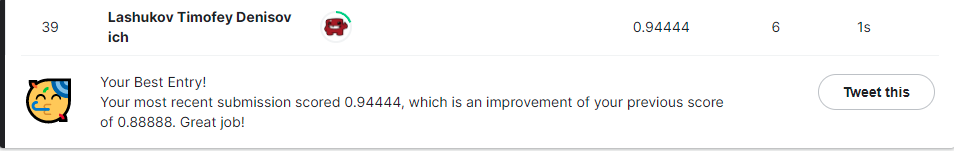

In [131]:
# Сохраню модель в pickle файл, для дальнейшего её использования
with open('nlp_classifier_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline3, file)

In [19]:
test_reviews

['Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти. Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться. ',
 'ценанадежность-неубиваемостьдолго держит батарею 4 дня стабильно как телефон, 3-4 как плеер если  постоянно долбиться в уши и звонить по паре часо на дню, игры и, конечно,  смс , в месяц около 200 шт набирается.  Максимальное время работы 5 дней в щадящем режиме.2 simqwerty рулит -после нее набор смс на обычных сенсорниках и кно